## Imports and Preprocess

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg
from scipy import stats

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(15,5)})

In [2]:
def calculate_corr_ci(df1, df2, alpha=0.05):
    correlations = []
    ci_lower = []
    ci_upper = []

    for column in df1.columns:
        r, _ = stats.pearsonr(df1[column], df2[column])
        r_z = np.arctanh(r)
        se = 1/np.sqrt(df1[column].size-3)
        z = stats.norm.ppf(1-alpha/2)
        lo_z, hi_z = r_z-z*se, r_z+z*se
        lo, hi = np.tanh((lo_z, hi_z))

        correlations.append(r)
        ci_lower.append(lo)
        ci_upper.append(hi)

    return correlations, ci_lower, ci_upper

Read result files

In [3]:
users = pd.read_csv('results/Calibrated Predictions Survey - users.csv', index_col='id')
preds = pd.read_csv('results/Calibrated Predictions Survey - predictions.csv', index_col='id')
labels = pd.read_csv('results/Calibrated Predictions Survey - labels.csv', index_col='id')
pred_test = pd.read_csv('results/Calibrated Predictions Survey - pred_test.csv', index_col='id')
label_test = pd.read_csv('results/Calibrated Predictions Survey - outcome_test.csv', index_col='id')
first_rate = pd.read_csv('results/Calibrated Predictions Survey - first_rate.csv', index_col='id')
last_rate = pd.read_csv('results/Calibrated Predictions Survey - last_rate.csv', index_col='id')

Replace values in data

In [4]:
preds_outcome = preds.applymap(lambda x: 1 if x >= 50 else 0)

map = {"Yes": 1, "No": 0}
label_test = label_test.applymap(lambda x: map.get(x, -1))

Get every model indexes

In [5]:
# get all unique models names in users that start with 'NN'
models_names = [model for model in users['model_name'].unique() if not model.startswith('NN')]
model_names = models_names.sort()
model_indexes = {}

# get indexes of every model name
for model in models_names:
    model_indexes[model] = users.index[users['model_name'] == model].tolist()

## Average users trust in the system

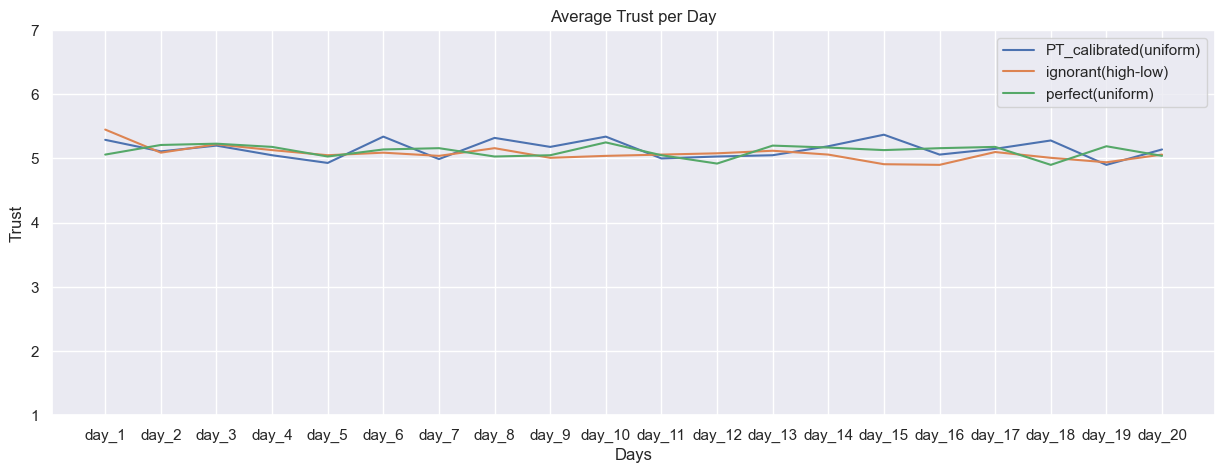

In [6]:
# calculate and plot average trust per day for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes[model]]
    last_rate_model_mean = last_rate_model.mean()
    p = sns.lineplot(x=last_rate.columns, y=last_rate_model_mean, 
                     dashes=False, markers=True, label=model)

p.set(ylim=(1, 7), title='Average Trust per Day', ylabel='Trust', xlabel='Days')
plt.show()

## Users actions according to system predictions

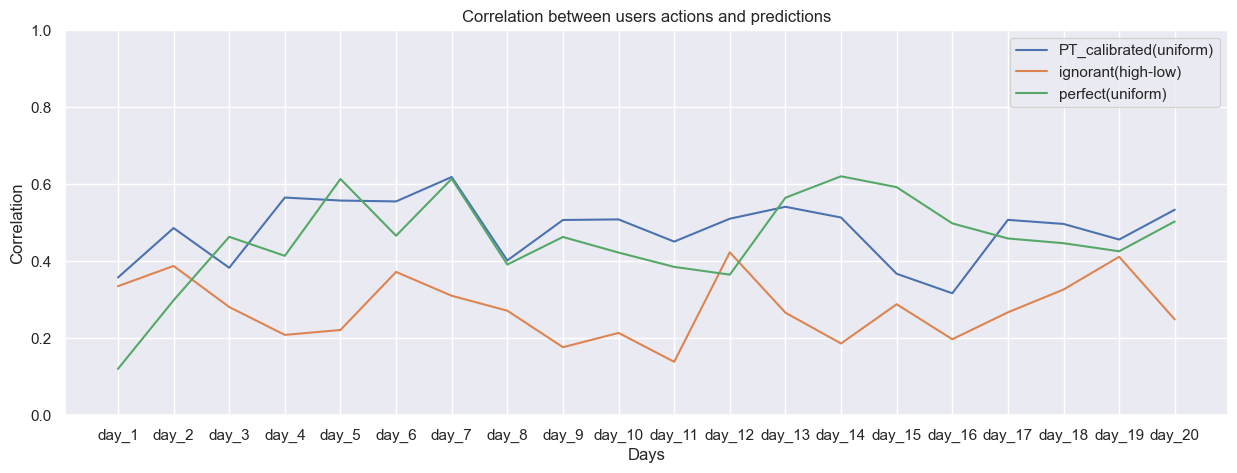

In [7]:
# calculate and plot correlation between model prediction and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes[model]]
    first_rate_model = first_rate.loc[model_indexes[model]]
    cors = preds_model.corrwith(first_rate_model, method='pearson')
    p = sns.lineplot(x=cors.index, y=cors, dashes=False, markers=True, label=model)

p.set(ylim=(0,1), title='Correlation between users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

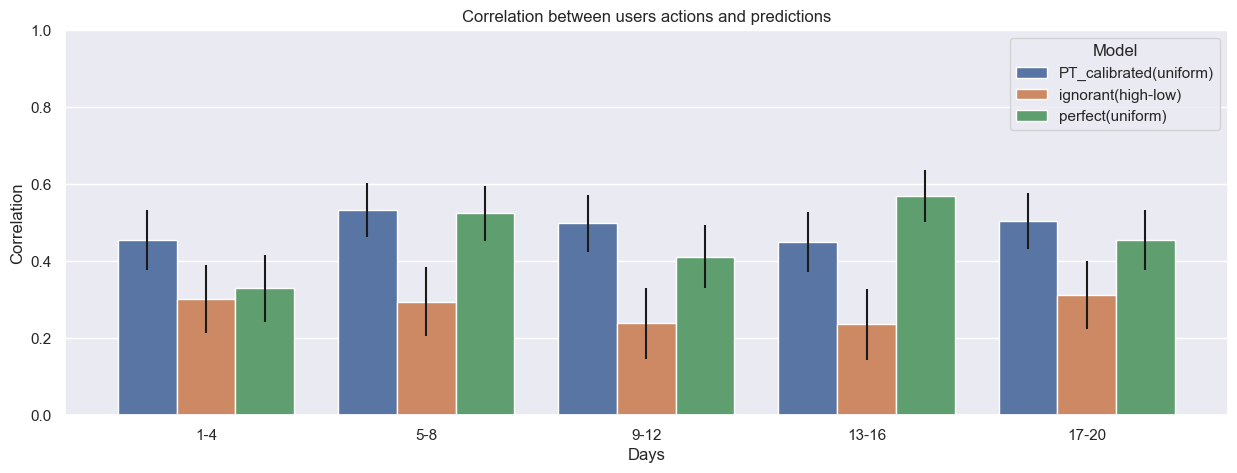

In [8]:
# calculate and plot correlation between model prediction and first_rate for each model
df_corr_ci = pd.DataFrame({'Model': [], 'Correlation': [], 'CI Lower': [], 'CI Upper': [], 'Day': []})

num_days_in_group = 4
grouped_days = [preds.columns[i:i+num_days_in_group] for i in range(0, len(preds.columns), num_days_in_group)]
grouped_days_names = ['1-4', '5-8', '9-12', '13-16', '17-20']

for i, model in enumerate(models_names):
    preds_model = preds.loc[model_indexes[model]]
    grouped_preds_model = pd.DataFrame()
    for group in grouped_days:
        grouped_preds_model = pd.concat([grouped_preds_model, preds_model[group].apply(list, axis=1)], axis=1)
    grouped_preds_model.columns = grouped_days_names
    grouped_preds_model = grouped_preds_model.explode(grouped_days_names)
    
    first_rate_model = first_rate.loc[model_indexes[model]]
    grouped_first_rate_model = pd.DataFrame()
    for group in grouped_days:
        grouped_first_rate_model = pd.concat([grouped_first_rate_model, first_rate_model[group].apply(list, axis=1)], axis=1)
    grouped_first_rate_model.columns = grouped_days_names
    grouped_first_rate_model = grouped_first_rate_model.explode(grouped_days_names)

    correlations, ci_lower, ci_upper = calculate_corr_ci(grouped_preds_model, grouped_first_rate_model)
    new_rows = pd.DataFrame({'Correlation': correlations, 'CI Lower': ci_lower, 'CI Upper': ci_upper, 'Model': model, 'Day': grouped_preds_model.columns})
    df_corr_ci = pd.concat([df_corr_ci, new_rows], ignore_index=True)

df_corr_ci['errorbar'] = (df_corr_ci['CI Upper'] - df_corr_ci['CI Lower'])/2

plt.figure(figsize=(15, 5))  
ax = sns.barplot(data=df_corr_ci, x='Day', y='Correlation', hue='Model')#, errorbar=('ci', 0.9), edgecolor='black')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=df_corr_ci['errorbar'], fmt="none", c="k")

ax.set(ylim=(0, 1), title='Correlation between users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

## Statistical significance on correlations

In [9]:
cors = pd.DataFrame(columns=models_names)

# create dataframe of correlations between model predictions and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes[model]]
    preds_model = preds_model.drop(columns=['day_1'])
    first_rate_model = first_rate.loc[model_indexes[model]]
    first_rate_model = first_rate_model.drop(columns=['day_1'])
    cors_model = preds_model.corrwith(first_rate_model, axis=1, method='pearson')
    cors_model = cors_model.dropna(how='any')
    cors[model] = cors_model.reset_index(drop=True)

# remove Nans
cors = cors.dropna(how='any')
cors

,PT_calibrated(uniform),ignorant(high-low),perfect(uniform)
0,-0.141580,-0.023707,0.953771
1,0.479920,0.977182,0.884375
2,0.980148,0.513799,0.019171
3,-0.379206,0.985670,0.056148
4,0.882207,-0.270707,0.945631
...,...,...,...
84,0.724370,0.563078,0.215847
85,0.843387,0.731876,0.850352
86,0.969632,0.857608,-0.235993
87,0.970492,-0.181271,-0.051414


In [10]:
print(cors.mean())

# check statistical significance between models with two tails t-test
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        t_statistic, p_value = stats.f_oneway(cors[model1], cors[model2])
        print(f'{model1} vs {model2}: f_statistic={t_statistic}, p_value={p_value}')

PT_calibrated(uniform)    0.467094
ignorant(high-low)        0.273309
perfect(uniform)          0.476283
dtype: float64
PT_calibrated(uniform) vs ignorant(high-low): f_statistic=9.05879316482634, p_value=0.0029984487747261868
PT_calibrated(uniform) vs perfect(uniform): f_statistic=0.01859552661695666, p_value=0.8916882674605701
ignorant(high-low) vs perfect(uniform): f_statistic=10.817583508732612, p_value=0.0012142530527852215


## Statistical significance on trust

In [11]:
trust = pd.DataFrame(columns=models_names)

# create dataframe of avg trust of users for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes[model]]
    last_rate_model = last_rate_model.mean(axis=1)
    trust[model] = last_rate_model.reset_index(drop=True)

trust

,PT_calibrated(uniform),ignorant(high-low),perfect(uniform)
0,4.80,4.85,5.55
1,7.00,5.25,3.85
2,5.10,4.05,5.25
3,5.25,5.15,4.65
4,4.55,4.10,5.90
...,...,...,...
95,6.70,1.50,6.15
96,5.35,4.50,5.50
97,4.45,6.55,5.80
98,3.70,5.85,5.95


In [12]:
print(trust.mean())
print()

# check statistical significance between models with repeated measures ANOVA
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        f_statistic, p_value = stats.f_oneway(trust[model1], trust[model2])
        print(f'{model1} vs {model2}: f_statistic={f_statistic}, p_value={p_value}')

PT_calibrated(uniform)    5.146
ignorant(high-low)        5.076
perfect(uniform)          5.114
dtype: float64

PT_calibrated(uniform) vs ignorant(high-low): f_statistic=0.23717699241385645, p_value=0.6267912119113388
PT_calibrated(uniform) vs perfect(uniform): f_statistic=0.07921621456891953, p_value=0.778656319919387
ignorant(high-low) vs perfect(uniform): f_statistic=0.07175864807261201, p_value=0.789072045510105


---
## Participants Errors

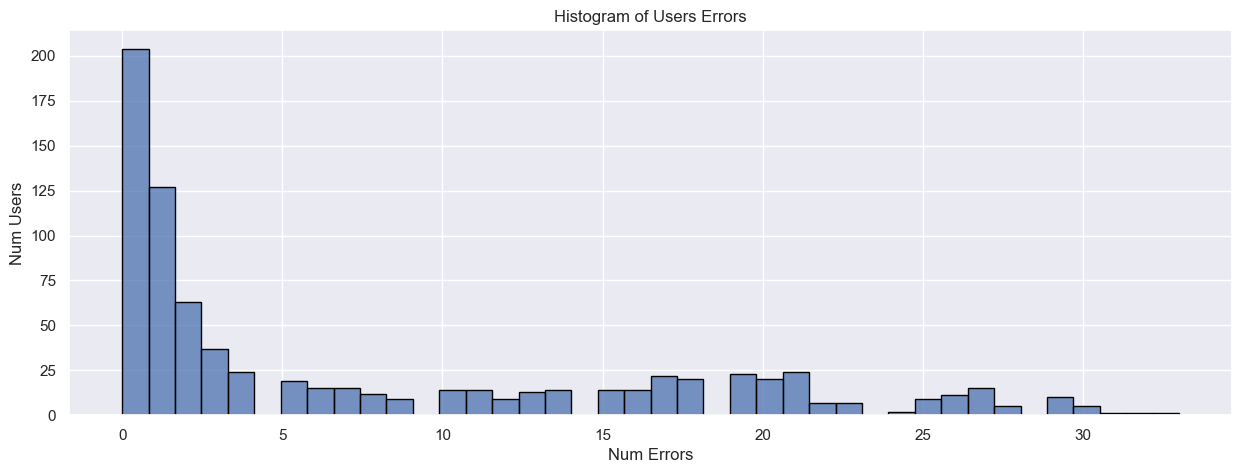

In [13]:
# calculate participants' errors
users_label_error = (labels != label_test).sum(axis=1)
users_pred_error = pred_test.apply(lambda x: (abs(x - preds.loc[x.name]) > 5).sum(), axis=1)
users_error = users_label_error + users_pred_error

# plot histogram of participants' error
p = sns.histplot(users_error, bins=40, edgecolor='black')
p.set(title='Histogram of Users Errors', xlabel='Num Errors', ylabel='Num Users')
plt.show()

---
## Analysis of good participants

In [14]:
allowed_errors = 20

good_users_idx = users_error[users_error <= allowed_errors].index
print(f'Number of users with less than {allowed_errors} errors is: {len(good_users_idx)}')
# sort from high to low users error in the range index of 100 to 206
# print(users_error[100:206].sort_values(ascending=False).head(10))

Number of users with less than 20 errors is: 702


Get every model indexes

In [15]:
# get good users
users_good = users.loc[good_users_idx]
model_indexes_good = {}

# get indexes of every model name
for model in models_names:
    model_indexes_good[model] = users_good.index[users_good['model_name'] == model].tolist()

## Average good users trust in the system

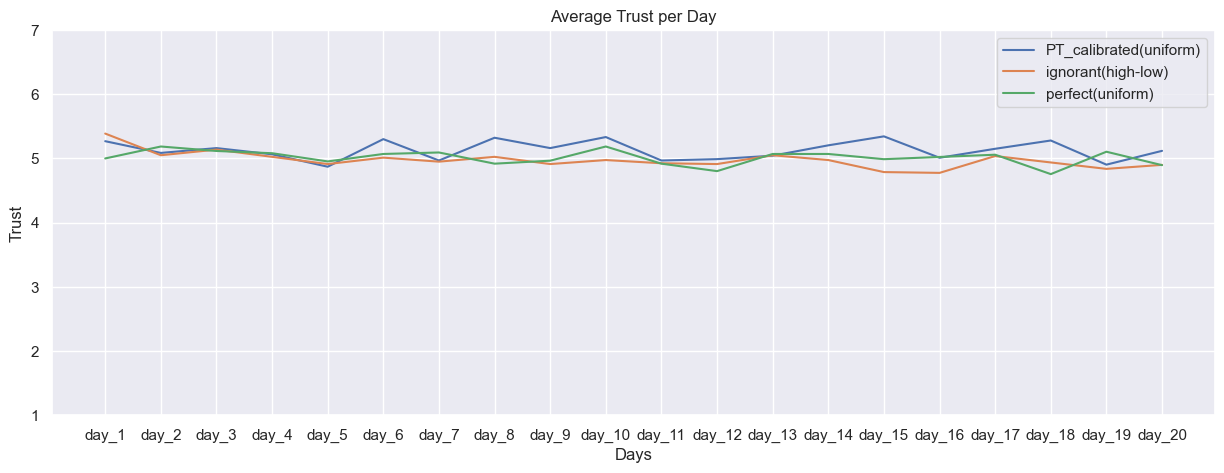

In [16]:
# calculate and plot average trust per day for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes_good[model]]
    last_rate_model_mean = last_rate_model.mean()
    p = sns.lineplot(x=last_rate.columns, y=last_rate_model_mean, 
                     dashes=False, markers=True, label=model)

p.set(ylim=(1, 7), title='Average Trust per Day', ylabel='Trust', xlabel='Days')
plt.show()

## Good users actions according to system predictions

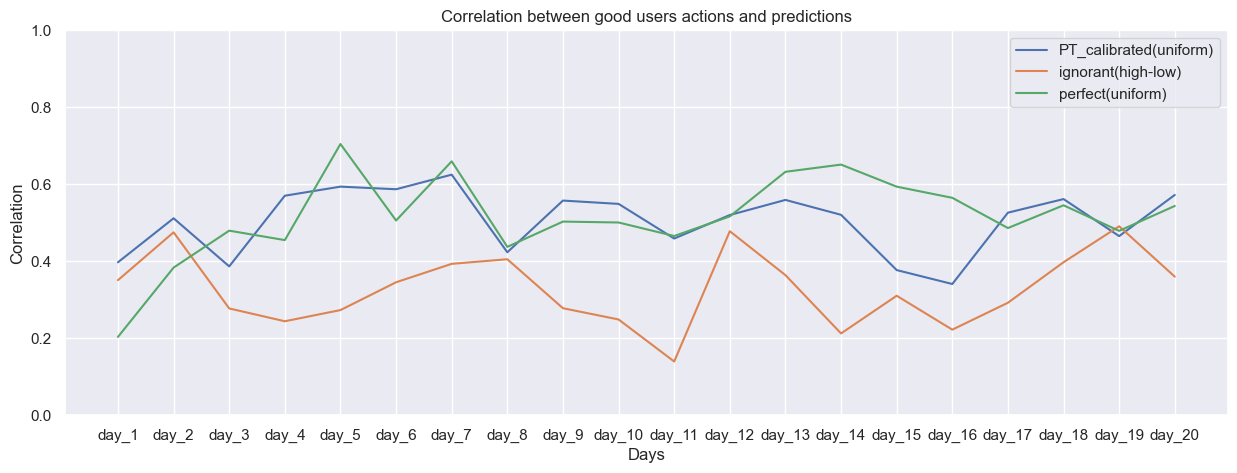

In [17]:
# calculate and plot correlation between model prediction and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes_good[model]]
    first_rate_model = first_rate.loc[model_indexes_good[model]]
    cors = preds_model.corrwith(first_rate_model, method='pearson')
    p = sns.lineplot(x=cors.index, y=cors, dashes=False, markers=True, label=model)

p.set(ylim=(0,1), title='Correlation between good users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

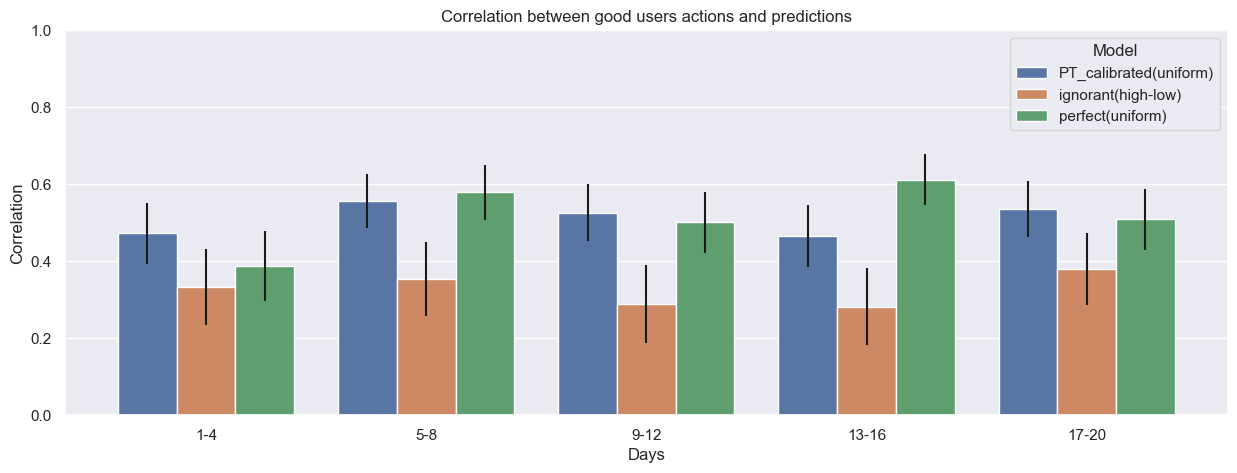

In [18]:
# calculate and plot correlation between model prediction and first_rate for each model
df_corr_ci = pd.DataFrame({'Model': [], 'Correlation': [], 'CI Lower': [], 'CI Upper': [], 'Day': []})

num_days_in_group = 4
grouped_days = [preds.columns[i:i+num_days_in_group] for i in range(0, len(preds.columns), num_days_in_group)]
grouped_days_names = ['1-4', '5-8', '9-12', '13-16', '17-20']

for i, model in enumerate(models_names):
    preds_model = preds.loc[model_indexes_good[model]]
    grouped_preds_model = pd.DataFrame()
    for group in grouped_days:
        grouped_preds_model = pd.concat([grouped_preds_model, preds_model[group].apply(list, axis=1)], axis=1)
    grouped_preds_model.columns = grouped_days_names
    grouped_preds_model = grouped_preds_model.explode(grouped_days_names)
    
    first_rate_model = first_rate.loc[model_indexes_good[model]]
    grouped_first_rate_model = pd.DataFrame()
    for group in grouped_days:
        grouped_first_rate_model = pd.concat([grouped_first_rate_model, first_rate_model[group].apply(list, axis=1)], axis=1)
    grouped_first_rate_model.columns = grouped_days_names
    grouped_first_rate_model = grouped_first_rate_model.explode(grouped_days_names)

    correlations, ci_lower, ci_upper = calculate_corr_ci(grouped_preds_model, grouped_first_rate_model)
    new_rows = pd.DataFrame({'Correlation': correlations, 'CI Lower': ci_lower, 'CI Upper': ci_upper, 'Model': model, 'Day': grouped_preds_model.columns})
    df_corr_ci = pd.concat([df_corr_ci, new_rows], ignore_index=True)

df_corr_ci['errorbar'] = (df_corr_ci['CI Upper'] - df_corr_ci['CI Lower'])/2

plt.figure(figsize=(15, 5))  
ax = sns.barplot(data=df_corr_ci, x='Day', y='Correlation', hue='Model')#, errorbar=('ci', 0.9), edgecolor='black')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=df_corr_ci['errorbar'], fmt="none", c="k")

ax.set(ylim=(0, 1), title='Correlation between good users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

## Check statistical significance on correlations

In [19]:
cors = pd.DataFrame(columns=models_names)

# create dataframe of correlations between model predictions and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes_good[model]]
    preds_model = preds_model.drop(columns=['day_1'])
    first_rate_model = first_rate.loc[model_indexes_good[model]]
    first_rate_model = first_rate_model.drop(columns=['day_1'])
    cors_model = first_rate_model.corrwith(preds_model, axis=1, method='pearson')
    cors_model = cors_model.dropna(how='any')
    cors[model] = cors_model.reset_index(drop=True)

cors = cors.dropna(how='any')
cors

,PT_calibrated(uniform),ignorant(high-low),perfect(uniform)
0,-0.141580,-0.023707,0.953771
1,0.479920,0.977182,0.884375
2,0.980148,0.513799,0.019171
3,0.882207,0.985670,0.945631
4,0.924918,-0.270707,0.646785
...,...,...,...
68,0.422368,0.563078,0.948079
69,0.473514,0.731876,0.713256
70,0.919203,0.857608,0.482299
71,-0.205872,-0.181271,-0.112717


In [20]:
print(cors.mean())
print()

# check statistical significance between models with two tails t-test
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        t_statistic, p_value = stats.f_oneway(cors[model1], cors[model2])
        print(f'{model1} vs {model2}: f_statistic={t_statistic}, p_value={p_value}')

PT_calibrated(uniform)    0.472323
ignorant(high-low)        0.338786
perfect(uniform)          0.543472
dtype: float64

PT_calibrated(uniform) vs ignorant(high-low): f_statistic=3.6966601733706104, p_value=0.05649566660569108
PT_calibrated(uniform) vs perfect(uniform): f_statistic=0.984371825431549, p_value=0.3227860875833929
ignorant(high-low) vs perfect(uniform): f_statistic=9.549719187925882, p_value=0.002401027329289072


## Check statistical significance on trust

In [21]:
trust = pd.DataFrame(columns=models_names)

# create dataframe of avg trust of users for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes[model]]
    last_rate_model = last_rate_model.mean(axis=1)
    trust[model] = last_rate_model.reset_index(drop=True)

trust

,PT_calibrated(uniform),ignorant(high-low),perfect(uniform)
0,4.80,4.85,5.55
1,7.00,5.25,3.85
2,5.10,4.05,5.25
3,5.25,5.15,4.65
4,4.55,4.10,5.90
...,...,...,...
95,6.70,1.50,6.15
96,5.35,4.50,5.50
97,4.45,6.55,5.80
98,3.70,5.85,5.95


In [22]:
print(trust.mean())
print()

# check statistical significance between models with repeated measures ANOVA
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        f_statistic, p_value = stats.f_oneway(trust[model1], trust[model2])
        print(f'{model1} vs {model2}: f_statistic={f_statistic}, p_value={p_value}')

PT_calibrated(uniform)    5.146
ignorant(high-low)        5.076
perfect(uniform)          5.114
dtype: float64

PT_calibrated(uniform) vs ignorant(high-low): f_statistic=0.23717699241385645, p_value=0.6267912119113388
PT_calibrated(uniform) vs perfect(uniform): f_statistic=0.07921621456891953, p_value=0.778656319919387
ignorant(high-low) vs perfect(uniform): f_statistic=0.07175864807261201, p_value=0.789072045510105
